# Observe reconstruction fidelity

In [77]:
import VAE_tybalt
from VAE_tybalt import VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns

In [78]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [79]:
model.load_state_dict(torch.load('vae_weights.pth'))

<All keys matched successfully>

Load data

In [80]:
tcga_tybalt_file_location = 'data/pancan_scaled_zeroone_rnaseq.tsv.gz'
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [81]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(torch.tensor(rnaseq_df.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [82]:
input_rnaseq_reconstruct.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.498772,0.430663,0.140697,0.036223,0.036814,0.035697,0.042761,0.043773,0.511842,0.511319,...,0.458977,0.545429,0.780027,0.627010,0.611930,0.367888,0.412525,0.504099,0.204982,0.627744
1,0.391797,0.318620,0.555675,0.160900,0.118926,0.365098,0.412676,0.151545,0.356362,0.323941,...,0.535075,0.492807,0.623793,0.514932,0.596077,0.425250,0.610927,0.130539,0.246538,0.599544
2,0.627619,0.335853,0.071946,0.008644,0.007347,0.014229,0.020355,0.014494,0.658156,0.598650,...,0.405278,0.531276,0.787660,0.566229,0.572994,0.306104,0.431254,0.479977,0.232090,0.677705
3,0.551226,0.302944,0.097538,0.010945,0.011275,0.019300,0.024334,0.013175,0.538229,0.511747,...,0.457215,0.518369,0.768436,0.610759,0.623087,0.316639,0.396505,0.508703,0.168914,0.652473
4,0.470877,0.361272,0.187557,0.035747,0.041423,0.067086,0.065257,0.055330,0.457916,0.412854,...,0.505508,0.448605,0.686259,0.545914,0.606203,0.396725,0.489138,0.433123,0.210458,0.581131


In [83]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.001953,0.240858
GSTT1,0.008121,0.225176
GSTM1,0.001031,0.219659
DDX3Y,0.007341,0.208478
EIF1AY,0.006881,0.206985


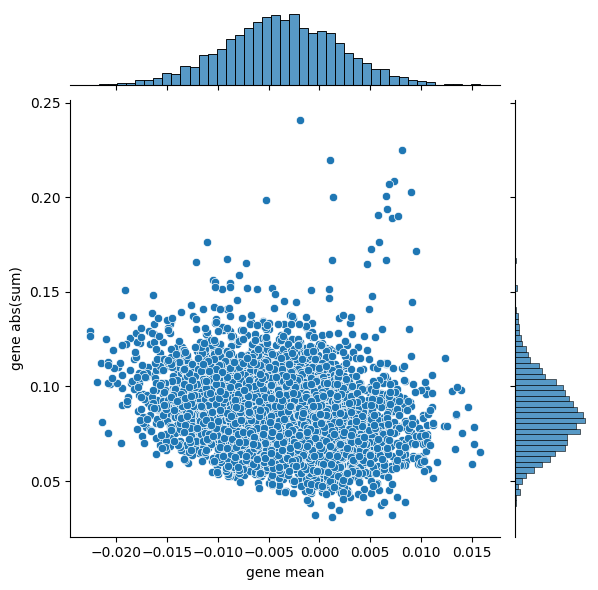

In [84]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

In [85]:
tcga_file_location = 'data/rescaled_5000_tcga_df_sort.tsv.gz'
target_file_location = 'data/rescaled_5000_target_df_sort.tsv.gz'
gtex_file_location = 'data/rescaled_5000_gtex_df_sort.tsv.gz'

tcga_df = pd.read_table(tcga_file_location)
target_df = pd.read_table(target_file_location)
gtex_df = pd.read_table(gtex_file_location)

tcga_df.drop(columns=tcga_df.columns[0], axis=1,  inplace=True)
target_df.drop(columns=target_df.columns[0], axis=1,  inplace=True)
gtex_df.drop(columns=gtex_df.columns[0], axis=1,  inplace=True)

tcga_df = tcga_df.dropna()
target_df = target_df.dropna()
gtex_df = gtex_df.dropna()

In [86]:
# How well does the model reconstruct the input RNAseq data
input_tcga_reconstruct_tensor = model.forward(torch.tensor(tcga_df.values, dtype=torch.float32))[0]
input_target_reconstruct_tensor = model.forward(torch.tensor(target_df.values, dtype=torch.float32))[0]
input_gtex_reconstruct_tensor = model.forward(torch.tensor(gtex_df.values, dtype=torch.float32))[0]

input_tcga_reconstruct = pd.DataFrame(input_tcga_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_target_reconstruct = pd.DataFrame(input_target_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_gtex_reconstruct = pd.DataFrame(input_gtex_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)

In [87]:
reconstruction_fidelity_tcga = tcga_df - input_tcga_reconstruct
reconstruction_fidelity_target = target_df - input_target_reconstruct
reconstruction_fidelity_gtex = gtex_df - input_gtex_reconstruct

gene_mean_tcga = reconstruction_fidelity_tcga.mean(axis=0)
gene_mean_target = reconstruction_fidelity_target.mean(axis=0)
gene_mean_gtex = reconstruction_fidelity_gtex.mean(axis=0)

gene_abssum_tcga = reconstruction_fidelity_tcga.abs().sum(axis=0).divide(tcga_df.shape[0])
gene_abssum_target = reconstruction_fidelity_target.abs().sum(axis=0).divide(target_df.shape[0])
gene_abssum_gtex = reconstruction_fidelity_gtex.abs().sum(axis=0).divide(gtex_df.shape[0])

gene_summary_tcga = pd.DataFrame([gene_mean_tcga, gene_abssum_tcga], index=['gene mean', 'gene abs(sum)']).T
gene_summary_target = pd.DataFrame([gene_mean_target, gene_abssum_target], index=['gene mean', 'gene abs(sum)']).T
gene_summary_gtex = pd.DataFrame([gene_mean_gtex, gene_abssum_gtex], index=['gene mean', 'gene abs(sum)']).T

In [88]:
gene_summary_tcga.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
125704,-0.677390,0.677780
200373,-0.667659,0.667758
2762,-0.658789,0.658942
8821,-0.652758,0.652919
5444,-0.648742,0.649190


In [89]:
gene_summary_target.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
7552,0.564604,0.565879
7409,0.531093,0.536610
286097,0.498936,0.505607
51166,0.464760,0.494778
9823,0.487783,0.494225


In [90]:
gene_summary_gtex.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
1995,-0.621698,0.623171
284656,-0.605637,0.607208
57449,-0.583656,0.584373
784,-0.559286,0.560152
124975,-0.557772,0.559255


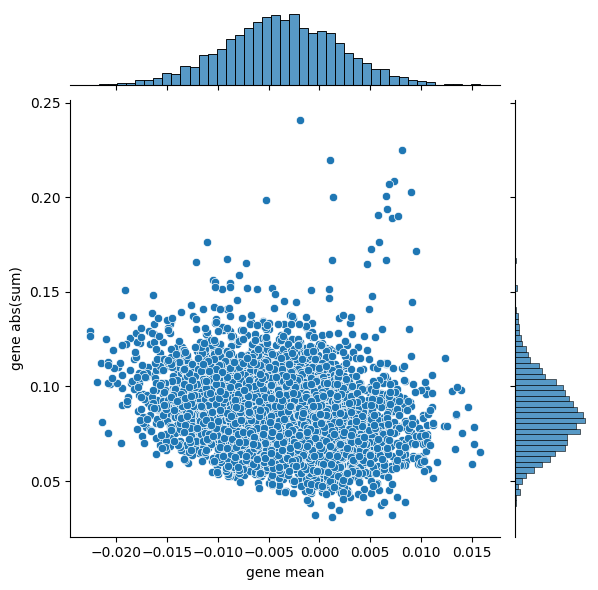

In [91]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

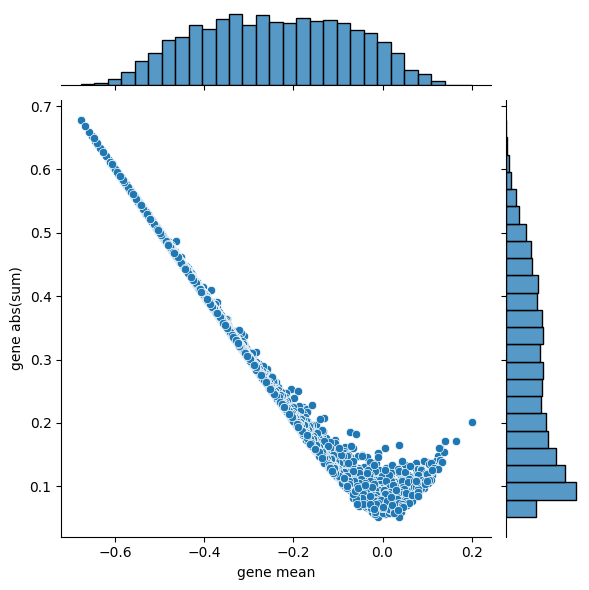

In [92]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_tcga)

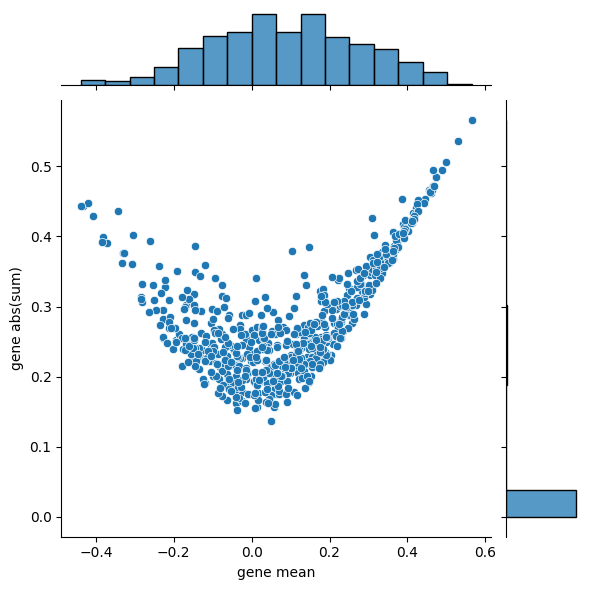

In [93]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_target)

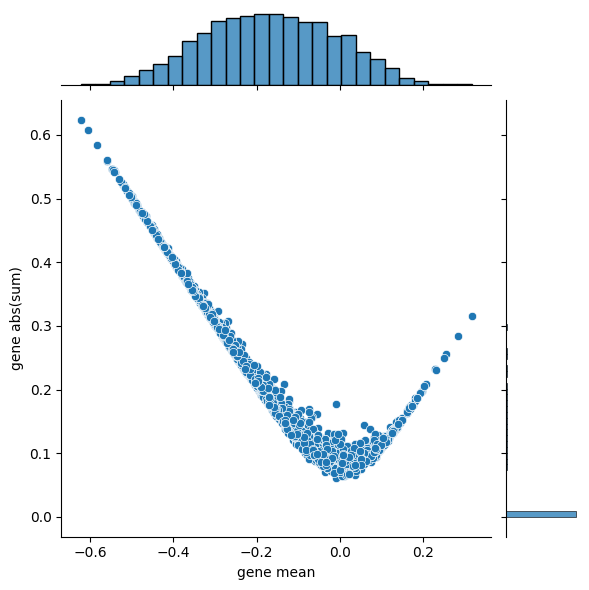

In [94]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_gtex)

Reconstruction after shuffling 

In [ ]:
import random
cols = rnaseq_df_test.columns.tolist()
random.shuffle(cols)

In [ ]:
cols_all_index = list(range(len(cols)))
cols_all_index_100 = list(sample(cols_all_index,100))
cols_all_index_1000 = list(sample(cols_all_index,1000))
cols_all_index_5000 = list(sample(cols_all_index,5000))

In [ ]:
permute_elements_100 = [cols[i] for i in cols_all_index_100]
permute_elements_1000 = [cols[i] for i in cols_all_index_1000]
permute_elements_5000 = [cols[i] for i in cols_all_index_5000]

In [ ]:
random.shuffle(permute_elements_100)
random.shuffle(permute_elements_1000)
random.shuffle(permute_elements_5000)

In [ ]:
permuted_cols_100 = cols.copy()
permuted_cols_1000 = cols.copy()
permuted_cols_5000 = cols.copy()

In [ ]:
for i, index in enumerate(cols_all_index_100):
    permuted_cols_100[index] = permute_elements_100[i]

for i, index in enumerate(cols_all_index_1000):
    permuted_cols_1000[index] = permute_elements_1000[i]

for i, index in enumerate(cols_all_index_5000):
    permuted_cols_5000[index] = permute_elements_5000[i]

In [ ]:
rnaseq_df_shuffled_100 = pd.DataFrame(rnaseq_df_test[permuted_cols_100])
rnaseq_df_shuffled_1000 = pd.DataFrame(rnaseq_df_test[permuted_cols_1000])
rnaseq_df_shuffled_5000 = pd.DataFrame(rnaseq_df_test[permuted_cols_5000])

In [ ]:
validation_loader_shuffled_100 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_100), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_1000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_1000), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_5000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_5000), 
                                                         batch_size=100, shuffle=True)

In [1]:
import numpy as np

In [2]:
np.mean([1,2,3])

2.0